## Analyze A/B Test Results

You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).  **Please save regularly.**

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
#import the dataset
df = pd.read_csv('ab_data.csv')

#show the first 5 rows
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
#show number of rows
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
#calculare the number of unique user_id 
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [5]:
#calculate the converted users
df['converted'].mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
len(df[((df['group']=='treatment') & (df['landing_page']!='new_page')) | ((df['group']!='treatment') 
                                                                          & (df['landing_page']=='new_page'))])

3893

f. Do any of the rows have missing values?

In [7]:
# Check if there are any missing values
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
#Remove the rows where `treatment` doesn't match with `new_page` or `control` doesn't match with 
#`old_page` then save cleand DataFrame in to `df2`
df1 = df.drop(df[(df.group =="treatment") & (df.landing_page != "new_page")].index)

df2 = df1.drop(df1[(df.group =="control") & (df1.landing_page != "old_page")].index)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [10]:
#calculare the number of unique user_id in df2 
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
duplicate_user = df2[df2.duplicated(['user_id'])]

c. What is the row information for the repeat **user_id**? 

In [12]:
duplicate_user

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
df2.drop(2893,inplace=True)

In [14]:
#Make sure that there are no duplicated rows 
df2.user_id.duplicated().sum()

0

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [15]:
df2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
df2[df2['group'] == 'control']['converted'].mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
df2[df2['group'] == 'treatment']['converted'].mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [18]:
(df2['landing_page'] == 'new_page').mean()

0.50006194422266881

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

According to the above results we can see that about 12% that received the old_page were converted and more than 11.5% that received the new_page were converted. So the results above do not give evidence that one page leads to more conversions.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

- $H_{0}$ : pnew <= pold

- $H_{1}$ : pnew > pold

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [19]:
p_new = df2['converted'].mean()
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [20]:
p_old = df2['converted'].mean()
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [21]:
nnew = df2[df2['group']=='treatment'].shape[0]
nnew

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [22]:
nold = df2[df2['group']=='control'].shape[0]
nold

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [23]:
new_page_converted = np.random.choice([1, 0], size = nnew, p = [p_new, (1 - p_new)]).mean()
new_page_converted

0.11968894088500448

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [24]:
old_page_converted = np.random.choice([1, 0], size = nold, p = [p_old, (1 - p_old)]).mean()
old_page_converted

0.12103335765518951

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [25]:
diff = new_page_converted - old_page_converted 
diff

-0.0013444167701850279

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [26]:
p_diffs = []

for i in range(10000):
    new_page_converted = np.random.choice([1, 0], size=nnew, p=[p_new, (1-p_new)]).mean()
    old_page_converted = np.random.choice([1, 0], size=nold, p=[p_old, (1-p_old)]).mean()
    diff = new_page_converted - old_page_converted 
    p_diffs.append(diff)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

Text(0.5,1,'Simulated page diffrence')

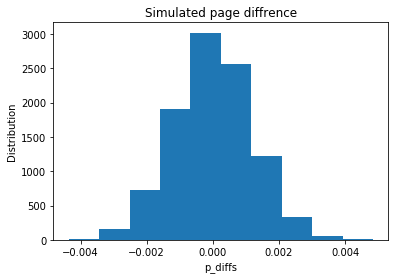

In [27]:
p_diffs = np.array(p_diffs)

plt.hist(p_diffs)
plt.xlabel('p_diffs')
plt.ylabel('Distribution')
plt.title('Simulated page diffrence')

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [28]:
df_control  = df2[df2['group'] == 'control']['converted'].mean()
df_treatment  = df2[df2['group'] == 'treatment']['converted'].mean()

diff_observed = df_treatment - df_control
diff_observed

-0.0015782389853555567

In [29]:
# checking the p_diffs mean 
p_diffs.mean()

3.1512088736692618e-06

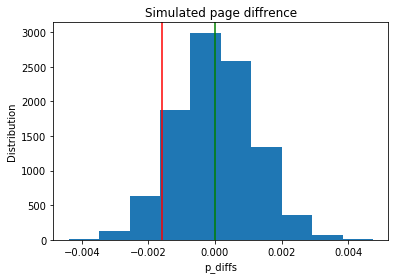

In [30]:
# plot line on the histogram for the observed statistic
nulls = np.random.normal(0, p_diffs.std(), p_diffs.size)
plt.hist(nulls)
plt.axvline(diff_observed, color='red')
plt.axvline(p_diffs.mean(), color='green')
plt.xlabel('p_diffs')
plt.ylabel('Distribution')
plt.title('Simulated page diffrence');
plt.legend()

In [31]:
# show the proportion of p_diffs greater than the observe difference
(p_diffs > diff_observed).mean()

0.90749999999999997

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

90.91% is the proportion of the p_diffs that are greater than the actual difference observed in ab_data.csv and also it's called p-value in the scientific studies and the p_value means that we can't reject the null hypothesis. Also we don't have evidence that the new_page has a higher conversion rate than the old_page.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [32]:
import statsmodels.api as sm

convert_old = df2[df2['group'] == 'control'].converted.sum()
convert_new = df2[df2['group'] == 'treatment'].converted.sum()
n_old = df2[df2['group'] == 'control'].converted.count()
n_new = df2[df2['group'] == 'treatment'].converted.count()
convert_old, convert_new, n_old, n_new

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


(17489, 17264, 145274, 145310)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [33]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
z_score, p_value

(1.3109241984234394, 0.90505831275902449)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

p-value of 0.9050 is almost the same as the p-value we get before and z-score value is positive so from all these computations we can safetly say that we can't reject the null hypothesis. 

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

In this case we have to use logistic regression because we want to predict something that has two outcomes only.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [34]:
# copy df2 in a df3 variable 
df3 = df2.copy()
df3.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [35]:
# add intercept and ab_page columns to the dataframe 
df3['intercept'] = 1
df3[['control','treatment']]= pd.get_dummies(df2['group'])

# dropping the control columns
df3 = df3.drop('control',axis = 1)

In [36]:
# adding ab_page column 
df3['ab_page'] = df3['treatment']
df3 = df3.drop('treatment', axis=1)

# checking the dataframe after amended
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [37]:
# defining the logistic regression object and store it in a varible 
log_model = sm.Logit(df3['converted'], df3[['intercept', 'ab_page']])

# fitting the model
test = log_model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [38]:
# providing the model summary 
test.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-01-12 16:13 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

The p-value associated with ab_page is 0.19. It is higher than 0.05. Thus, the coefficient is not significant.
Alternative hypothesis from part II shows that the conversion rate of the old_page is less than the conversion rate of the new_page and this is a one-tailed case. But the logistic regression is a two-tailed case because we explore two possible outcomes.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

Sure it will be better to consider other potential factors that can influence the conversion rate and sure this will lead to more accurate results.
The only disadvantage I can say is we need to choose the factors carefully to avoid complexity. 

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [39]:
df_countries = pd.read_csv('./countries.csv')
df_new = df_countries.set_index('user_id').join(df3.set_index('user_id'), how='inner')

In [40]:
# checking the new dataframe
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [41]:
# check the unique countries 
df_new.country.unique()

array(['UK', 'US', 'CA'], dtype=object)

In [42]:
# calculate the mean of the conversion rate
df_new.ab_page.mean()

0.50006194422266881

In [43]:
# calculate the mean of the conversion rate for each country
df_new.groupby(['country']).mean()

,converted,intercept,ab_page
country,,,
CA,0.115318,1.0,0.503552
UK,0.120594,1.0,0.498247
US,0.119547,1.0,0.500459


In [59]:
# Create the necessary dummy variables
df_new[['CA','UK', 'US']] = pd.get_dummies(df_new['country'])

In [60]:
# we drop US column because we need only two dummy variables for three results 
df_new.drop(['US'], axis=1, inplace=True)

In [61]:
# checking the dataframe 
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK
user_id,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [62]:
# fitting model
df_new['intercept'] = 1
df_new['ab_UK'] = df_new['ab_page'] * df_new['UK']
df_new['ab_CA'] = df_new['ab_page'] * df_new['CA']
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,ab_UK,ab_CA
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,1,0


In [63]:
# defining logistic regression object 
log_model = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'CA', 'UK', 'ab_CA', 'ab_UK']])
test = log_model.fit()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


In [64]:
test.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-01-12 16:23 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9865    0.0096  -206.3440  0.0000  -2.0053  -1.9676
ab_page      -0.0206    0.0137    -1.5052  0.1323  -0.0473   0.0062
CA           -0.0175    0.0377    -0.4652  0.6418  -0.0914   0.0563
UK           -0.0057    0.0188    -0.3057  0.7598  -0.0426   0.0311
ab_CA        -0.0469    0.0538    -0.8718  0.3833  -0.1523   0.0585
ab_UK         0.0314    0.0266     1.1807  0.2377  -0.0207   0.0835
==================================================================

"""

## Summary

We can see that the p_value for both interaction is higher than 0.05. So this means the influence of landing_page in the US is not different to the influence of landing_page in the other countries.
And also the influence of landing_page in Canada is not different to the influence of landing_page in the other countries.

## Conclusion

In this project, I tried to decide whether the company should implement a new landing page or keep the old page using the following approaches:

    -Probability approach
    -A/B test approach
    -Regression approach


### 1- Probability Approach:

The probability of an individual receiving the new page is 0.5000 and that means it's almost 50% which means that there is also 50% chance that an individual will receive the old page. 

### 2- A/B test Approach:


    - In A/B test our hypothesis is to test whether the new page will increase conversion rate or not 
    - The p_value to be 0.9050 and that means we can't reject the null hypothesis
    - Then using the built-in stats.proportions_ztest I computed z-score and p-value which confirmed our earlier   p-value and failure to reject null hypothesis


### 3- Regression Approach:


    I looked at exploring two possible outcomes whether new page is better or not.
    With the help of logistic regression results, I found the same z-score as well as p-value corresponding two-tailed case
    Then I tried to figure out if resident countries of users had an impact on conversion rate but the result gave a similar outlook and suggested that the countries have no impact on the conversion rate.


Finally, there is no enough evidence that the new_page increases the conversion rate as compared to the old_page. This is based on the probability figures, A/B testand regression. 
Also if we consider countries there is also no evidence that the countries (US, CA and UK) influence the conversion rate.

### Recommendation

I recommend that there is no need for the new landing page as the statistics above shows that it doesn't affect the conversion rate so there is no need to increase expenses. It will be preferred to focus on other factors that can increase the conversion rate. 

<a id='conclusions'></a>
## Finishing Up

> Congratulations!  You have reached the end of the A/B Test Results project!  You should be very proud of all you have accomplished!

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the rubric (found on the project submission page at the end of the lesson). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [65]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0